# Connexion à l'environement Google

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import des dépendances et des images

In [ ]:
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from math import floor


def zero():
    return np.random.uniform(0.0, 0.01, size = [1])

def one():
    return np.random.uniform(0.99, 1.0, size = [1])

def noise(n):
    return np.random.uniform(-1.0, 1.0, size = [n, 4096])

import os
import zipfile
from PIL import Image
import numpy as np

print("Importing Images...")

Images = []
#zip_file_path = "/content/drive/MyDrive/data/gan/images/birme_sport_tshirt_images_256x256.zip"
extracted_folder_path = "/content/drive/MyDrive/data/gan/images/t-shirt-images-256x256"  # Chemin où les images seront extraites

# Extraction du fichier zip
#with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#    zip_ref.extractall(extracted_folder_path)

# Chargement des images
files = sorted([f for f in os.listdir(extracted_folder_path) if f.endswith('.jpg')])
for file_name in files:
    temp1 = Image.open(os.path.join(extracted_folder_path, file_name))
    temp = np.array(temp1.convert('RGB'), dtype='float32')
    Images.append(temp / 255)
    Images.append(np.flip(Images[-1], 1))


from keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dense, AveragePooling2D, GaussianNoise
from keras.layers import Reshape, UpSampling2D, Activation, Dropout, Flatten, Conv2DTranspose
from keras.models import model_from_json, Sequential
from keras.optimizers import Adam
from keras.models import load_model





Importing Images...


# Création des classes GAN

In [ ]:

class GAN(object):

    def __init__(self):

        #Models
        self.D = None
        self.G = None

        self.OD = None

        self.DM = None
        self.AM = None

        #Config
        self.LR = 0.0001
        self.steps = 1

    def discriminator(self):

        if self.D:
            return self.D

        self.D = Sequential()

        #add Gaussian noise to prevent Discriminator overfitting
        self.D.add(GaussianNoise(0.2, input_shape = [256, 256, 3]))

        #256x256x3 Image
        self.D.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())

        #128x128x8
        self.D.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())

        #64x64x16
        self.D.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())

        #32x32x32
        self.D.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())

        #16x16x64
        self.D.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())

        #8x8x128
        self.D.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())

        #4x4x256
        self.D.add(Flatten())

        #256
        self.D.add(Dense(128))
        self.D.add(LeakyReLU(0.2))

        self.D.add(Dense(1, activation = 'sigmoid'))

        return self.D

    def generator(self):

        if self.G:
            return self.G

        self.G = Sequential()

        self.G.add(Reshape(target_shape = [1, 1, 4096], input_shape = [4096]))

        #1x1x4096
        self.G.add(Conv2DTranspose(filters = 256, kernel_size = 4))
        self.G.add(Activation('relu'))

        #4x4x256 - kernel sized increased by 1
        self.G.add(Conv2D(filters = 256, kernel_size = 4, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())

        #8x8x256 - kernel sized increased by 1
        self.G.add(Conv2D(filters = 128, kernel_size = 4, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())

        #16x16x128
        self.G.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())

        #32x32x64
        self.G.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())

        #64x64x32
        self.G.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())

        #128x128x16
        self.G.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())

        #256x256x8
        self.G.add(Conv2D(filters = 3, kernel_size = 3, padding = 'same'))
        self.G.add(Activation('sigmoid'))

        return self.G

    def DisModel(self):

        if self.DM == None:
            self.DM = Sequential()
            self.DM.add(self.discriminator())

        self.DM.compile(optimizer = Adam(lr = self.LR * (0.85 ** floor(self.steps / 10000))), loss = 'binary_crossentropy')

        return self.DM

    def AdModel(self):

        if self.AM == None:
            self.AM = Sequential()
            self.AM.add(self.generator())
            self.AM.add(self.discriminator())

        self.AM.compile(optimizer = Adam(lr = self.LR * (0.85 ** floor(self.steps / 10000))), loss = 'binary_crossentropy')

        return self.AM

    def sod(self):

        self.OD = self.D.get_weights()

    def lod(self):

        self.D.set_weights(self.OD)


In [ ]:
class Model_GAN(object):

    def __init__(self):
        self.GAN = GAN()
        self.DisModel = self.GAN.DisModel()
        self.AdModel = self.GAN.AdModel()
        self.generator = self.GAN.generator()

    def train(self, batch = 16):
        (a, b) = self.train_dis(batch)
        c = self.train_gen(batch)

        print(f"D Real: {str(a)}, D Fake: {str(b)}, G All: {str(c)}")

        # Saving rate
        if self.GAN.steps % 50 == 0:
            self.save(floor(self.GAN.steps / 1000))
            self.evaluate()

        if self.GAN.steps % 5000 == 0:
            self.GAN.AM = None
            self.GAN.DM = None
            self.AdModel = self.GAN.AdModel()
            self.DisModel = self.GAN.DisModel()

        self.GAN.steps = self.GAN.steps + 1

    def train_dis(self, batch):
        # Get Real Images
        im_no = random.randint(0, len(Images) - batch - 1)
        train_data = Images[im_no : im_no + int(batch / 2)]
        label_data = []
        for i in range(int(batch / 2)):
            label_data.append(zero())

        d_loss_real = self.DisModel.train_on_batch(np.array(train_data), np.array(label_data))

        # Get Fake Images
        train_data = self.generator.predict(noise(int(batch / 2)))
        label_data = []
        for i in range(int(batch / 2)):
            label_data.append(one())

        d_loss_fake = self.DisModel.train_on_batch(train_data, np.array(label_data))

        return (d_loss_real, d_loss_fake)

    def train_gen(self, batch):
        self.GAN.sod()
        label_data = []
        for i in range(int(batch)):
            label_data.append(zero())

        g_loss = self.AdModel.train_on_batch(noise(batch), np.array(label_data))

        self.GAN.lod()

        return g_loss

    def evaluate(self):
        im_no = random.randint(0, len(Images) - 1)
        im1 = Images[im_no]

        im2 = self.generator.predict(noise(2))

        plt.figure(1)
        plt.imshow(im1)

        plt.figure(2)
        plt.imshow(im2[0])

        plt.figure(3)
        plt.imshow(im2[1])

        plt.show()

    def save(self, num):
        gen_json = self.GAN.G.to_json()
        dis_json = self.GAN.D.to_json()

        with open("/content/drive/MyDrive/GAN_mardi/Models4/gen.json", "w+") as json_file:
            json_file.write(gen_json)

        with open("/content/drive/MyDrive/GAN_mardi/Models4/dis.json", "w+") as json_file:
            json_file.write(dis_json)

        self.GAN.G.save_weights("/content/drive/MyDrive/GAN_mardi/Models4/gen"+str(num)+".h5")
        self.GAN.D.save_weights("/content/drive/MyDrive/GAN_mardi/Models4/dis"+str(num)+".h5")

        print(f"Model number {str(num)} Saved!")

    def load(self, num):
        steps1 = self.GAN.steps

        self.GAN = None
        self.GAN = GAN()

        # Generator
        gen_file = open("/content/drive/MyDrive/GAN_mardi/Models3/gen.json", 'r')
        gen_json = gen_file.read()
        gen_file.close()

        self.GAN.G = model_from_json(gen_json)
        self.GAN.G.load_weights("/content/drive/MyDrive/GAN_mardi/Models3/gen"+str(num)+".h5")

        # Discriminator
        dis_file = open("/content/drive/MyDrive/GAN_mardi/Models3/dis.json", 'r')
        dis_json = dis_file.read()
        dis_file.close()

        self.GAN.D = model_from_json(dis_json)
        self.GAN.D.load_weights("/content/drive/MyDrive/GAN_mardi/Models3/dis"+str(num)+".h5")

        # Reinitialize
        self.generator = self.GAN.generator()
        self.DisModel = self.GAN.DisModel()
        self.AdModel = self.GAN.AdModel()

        self.GAN.steps = steps1

    def eval2(self, num = 0):
        im2 = self.generator.predict(noise(48))

        r1 = np.concatenate(im2[:8], axis = 1)
        r2 = np.concatenate(im2[8:16], axis = 1)
        r3 = np.concatenate(im2[16:24], axis = 1)
        r4 = np.concatenate(im2[24:32], axis = 1)
        r5 = np.concatenate(im2[32:40], axis = 1)
        r6 = np.concatenate(im2[40:48], axis = 1)

        c1 = np.concatenate([r1, r2, r3, r4, r5, r6], axis = 0)

        x = Image.fromarray(np.uint8(c1*255))

        x.save("/content/drive/MyDrive/GAN_mardi/Results4/i"+str(num)+".png")

In [ ]:
import os

if not os.path.exists('Results4'):
    os.mkdir('Results4')

if not os.path.exists('Models4'):
    os.mkdir('Models4')




# Fine-tuning du GAN

Ce code semble être une boucle d'apprentissage pour un modèle GAN (Generative Adversarial Network). Voici ce que fait chaque partie du code :

1. Initialisation du modèle GAN :
   - Un objet `Model_GAN` est créé. C'est probablement une classe qui encapsule à la fois le générateur (G) et le discriminateur (D) du GAN, ainsi que toutes les méthodes nécessaires pour l'entraînement.
   - Les résumés du modèle discriminatif (D) et du modèle générateur (G) sont imprimés, montrant les architectures des deux parties du GAN.

2. Boucle d'entraînement :
   - La boucle `while` exécute l'entraînement jusqu'à ce que le nombre d'itérations atteigne 500 000. Cela est contrôlé par la condition `model.GAN.steps < 500000`.
   - À chaque itération de la boucle :
     - Le modèle est entraîné avec `model.train()`, ce qui probablement effectue une itération d'entraînement pour le GAN. La façon dont cela est implémenté dépendrait des détails de la méthode `train()` dans la classe `Model_GAN`.
     - Si le nombre d'itérations est un multiple de 500, un message est imprimé pour indiquer le début d'un nouveau tour (`Round`).
     - Si le nombre d'itérations est un multiple de 1000, un message est imprimé et la méthode `eval2()` est appelée, probablement pour évaluer la performance du modèle à cette étape spécifique de l'entraînement.

En résumé, ce code effectue un entraînement itératif d'un modèle GAN, imprimant périodiquement des informations sur l'avancement de l'entraînement et évaluant périodiquement le modèle à certaines étapes.

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 1, 1, 4096)        0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 4, 4, 256)         16777472  
 Transpose)                                                      
                                                                 
 activation_8 (Activation)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 4, 4, 256)         1048832   
                                                                 
 batch_normalization_15 (Ba  (None, 4, 4, 256)         1024      
 tchNormalization)                                               
                                                                 
 activation_9 (Activation)   (None, 4, 4, 256)        

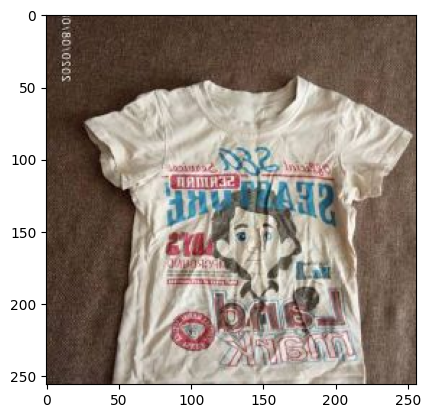

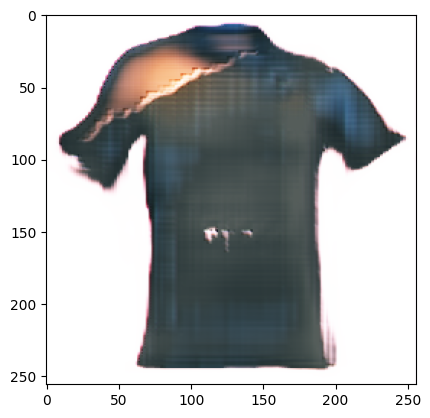

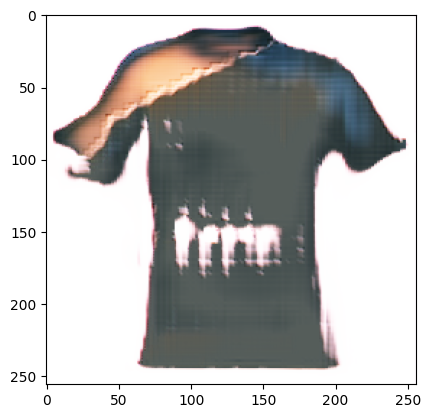

1/1 [==============================] - 0s 20ms/step
D Real: 0.03557366132736206, D Fake: 0.04906109720468521, G All: 4.101611137390137
1/1 [==============================] - 0s 19ms/step
D Real: 0.04658681899309158, D Fake: 0.03193388879299164, G All: 4.265455722808838
1/1 [==============================] - 0s 27ms/step
D Real: 0.03661658614873886, D Fake: 0.05271601676940918, G All: 4.825484275817871
1/1 [==============================] - 0s 20ms/step
D Real: 0.05252145230770111, D Fake: 0.03815971314907074, G All: 4.3537445068359375
1/1 [==============================] - 0s 17ms/step
D Real: 0.04829779639840126, D Fake: 0.045377217233181, G All: 3.982032299041748
1/1 [==============================] - 0s 19ms/step
D Real: 0.0589233934879303, D Fake: 0.03622956573963165, G All: 4.345012664794922
1/1 [==============================] - 0s 26ms/step
D Real: 0.045599766075611115, D Fake: 0.042756713926792145, G All: 4.371299743652344
1/1 [==============================] - 0s 19ms/step
D R

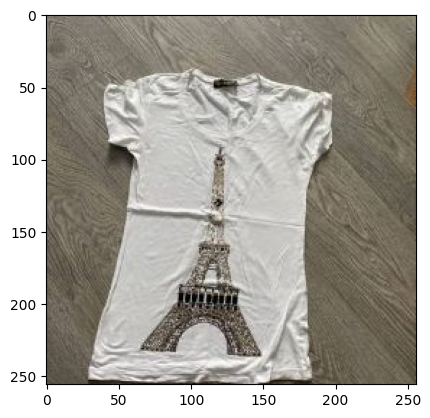

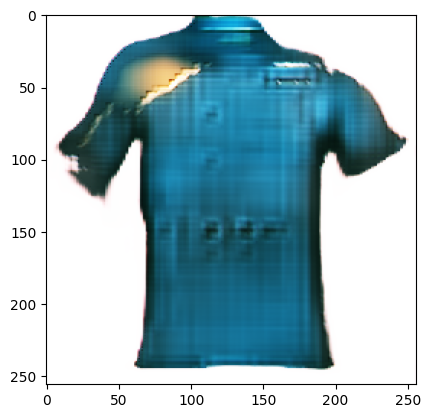

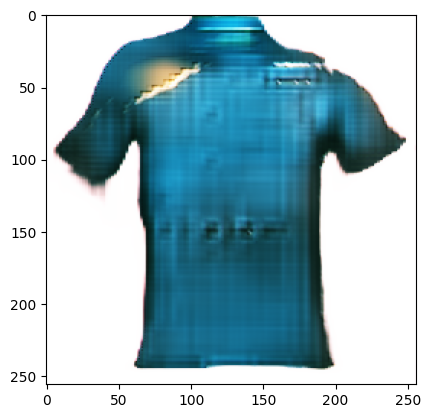

1/1 [==============================] - 0s 20ms/step
D Real: 0.043813638389110565, D Fake: 0.1252242773771286, G All: 4.535965919494629
1/1 [==============================] - 0s 18ms/step
D Real: 0.03960110619664192, D Fake: 0.044185981154441833, G All: 3.559074640274048
1/1 [==============================] - 0s 18ms/step
D Real: 0.0402812659740448, D Fake: 0.05370542034506798, G All: 4.204255104064941
1/1 [==============================] - 0s 20ms/step
D Real: 0.044954657554626465, D Fake: 0.03124588541686535, G All: 4.710073471069336
1/1 [==============================] - 0s 19ms/step
D Real: 0.08346513658761978, D Fake: 0.04094148054718971, G All: 4.94038724899292
1/1 [==============================] - 0s 19ms/step
D Real: 0.03496212884783745, D Fake: 0.03451007604598999, G All: 5.165719509124756
1/1 [==============================] - 0s 19ms/step
D Real: 0.036908283829689026, D Fake: 0.037520818412303925, G All: 5.099356651306152
1/1 [==============================] - 0s 19ms/step
D

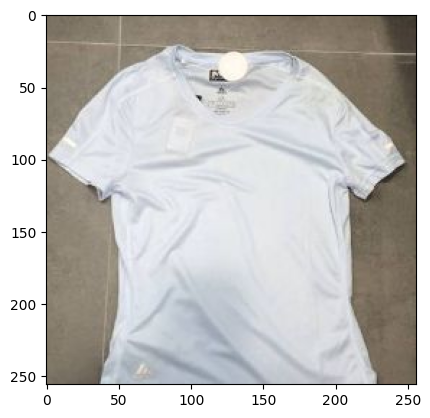

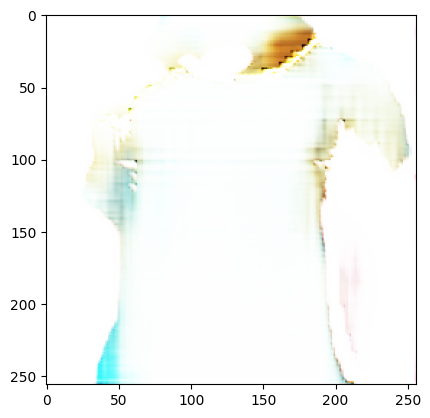

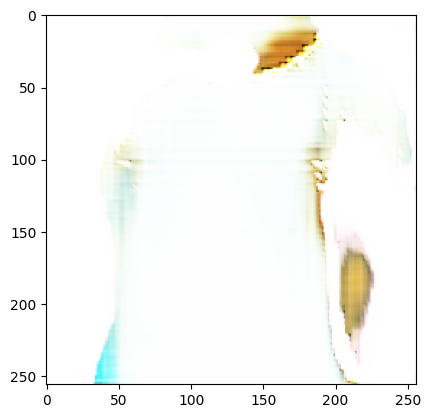

1/1 [==============================] - 0s 20ms/step
D Real: 0.2002081573009491, D Fake: 0.03928764909505844, G All: 5.1255998611450195
1/1 [==============================] - 0s 20ms/step
D Real: 0.06722839176654816, D Fake: 0.07998223602771759, G All: 7.241485595703125
1/1 [==============================] - 0s 23ms/step
D Real: 0.19843855500221252, D Fake: 0.06838847696781158, G All: 5.605743408203125
1/1 [==============================] - 0s 19ms/step
D Real: 0.04775390774011612, D Fake: 0.04133221134543419, G All: 6.16373872756958
1/1 [==============================] - 0s 19ms/step
D Real: 0.17580172419548035, D Fake: 0.09350526332855225, G All: 5.912181377410889
1/1 [==============================] - 0s 19ms/step
D Real: 0.053249113261699677, D Fake: 0.04859166219830513, G All: 5.507680892944336
1/1 [==============================] - 0s 19ms/step
D Real: 0.060713090002536774, D Fake: 0.027295032516121864, G All: 4.847989082336426
1/1 [==============================] - 0s 19ms/step
D

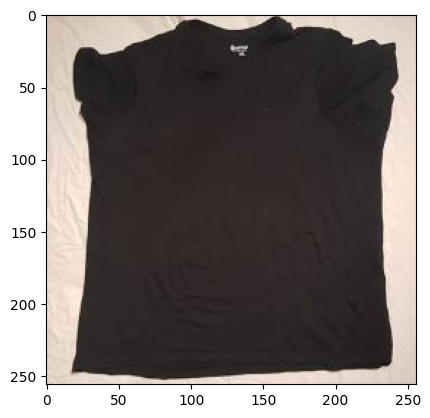

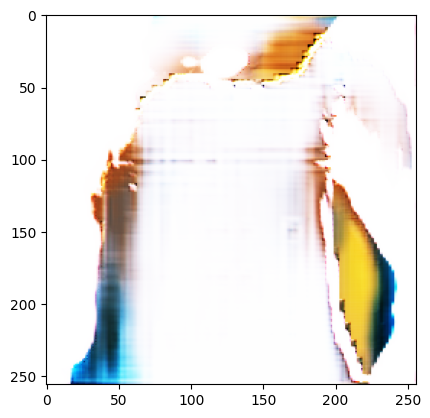

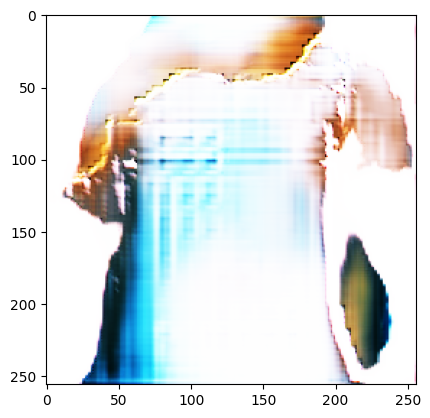

1/1 [==============================] - 0s 20ms/step
D Real: 0.05592549592256546, D Fake: 0.0360235795378685, G All: 5.040007591247559
1/1 [==============================] - 0s 21ms/step
D Real: 0.045161932706832886, D Fake: 0.051797203719615936, G All: 4.549686431884766
1/1 [==============================] - 0s 18ms/step
D Real: 0.03500991687178612, D Fake: 0.0391932874917984, G All: 4.973163604736328
1/1 [==============================] - 0s 22ms/step
D Real: 0.035878583788871765, D Fake: 0.07505723834037781, G All: 4.559686183929443
1/1 [==============================] - 0s 19ms/step
D Real: 0.07885979115962982, D Fake: 0.02903185412287712, G All: 5.77379035949707
1/1 [==============================] - 0s 19ms/step
D Real: 0.6294183731079102, D Fake: 0.03154753893613815, G All: 4.3879899978637695
1/1 [==============================] - 0s 20ms/step
D Real: 0.05883510783314705, D Fake: 0.048674240708351135, G All: 4.247592926025391
1/1 [==============================] - 0s 18ms/step
D 

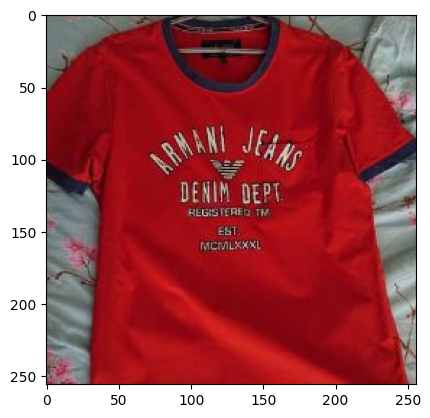

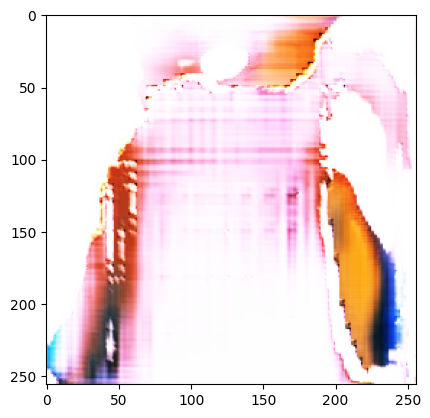

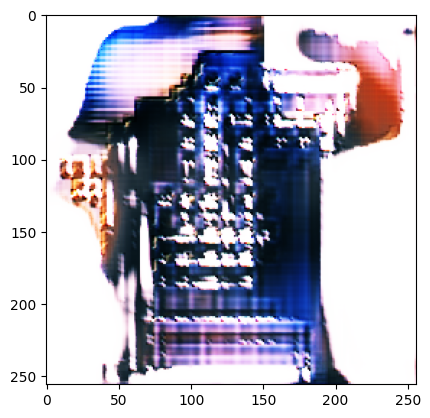

1/1 [==============================] - 0s 20ms/step
D Real: 0.06538185477256775, D Fake: 0.062144916504621506, G All: 4.180136203765869
1/1 [==============================] - 0s 19ms/step
D Real: 0.03469780460000038, D Fake: 0.08216091990470886, G All: 4.5019211769104
1/1 [==============================] - 0s 19ms/step
D Real: 0.028700582683086395, D Fake: 0.05311296880245209, G All: 5.523916244506836
1/1 [==============================] - 0s 19ms/step
D Real: 0.031697291880846024, D Fake: 0.036929234862327576, G All: 5.6940412521362305
1/1 [==============================] - 0s 19ms/step
D Real: 0.06111370772123337, D Fake: 0.032937295734882355, G All: 6.09092903137207
1/1 [==============================] - 0s 20ms/step
D Real: 0.056883081793785095, D Fake: 0.03525492548942566, G All: 6.785971641540527
1/1 [==============================] - 0s 20ms/step
D Real: 0.04311365634202957, D Fake: 0.030952828004956245, G All: 5.796300888061523
1/1 [==============================] - 0s 21ms/ste

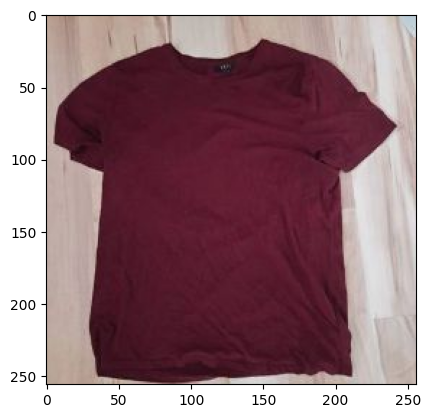

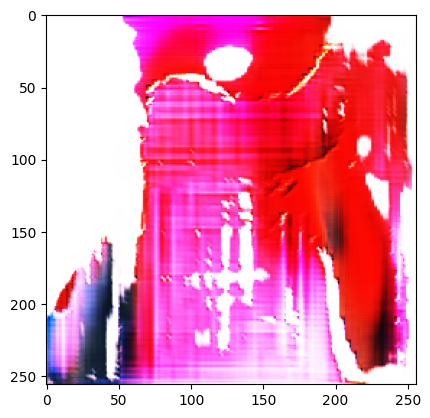

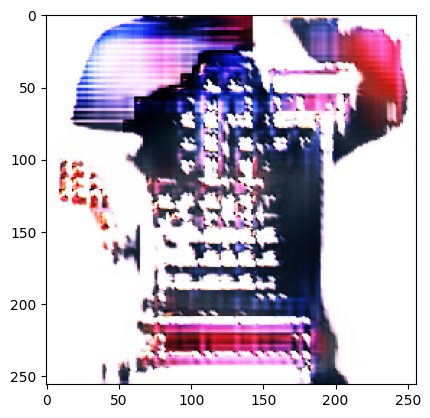

1/1 [==============================] - 0s 19ms/step
D Real: 0.08137553185224533, D Fake: 0.04647171497344971, G All: 6.8815107345581055
1/1 [==============================] - 0s 20ms/step
D Real: 0.04688972234725952, D Fake: 0.03741028159856796, G All: 5.115726470947266
1/1 [==============================] - 0s 19ms/step
D Real: 0.05509110167622566, D Fake: 0.03905230760574341, G All: 6.422707557678223
1/1 [==============================] - 0s 18ms/step
D Real: 0.044704683125019073, D Fake: 0.0316394567489624, G All: 5.69310188293457
1/1 [==============================] - 0s 19ms/step
D Real: 0.03551587462425232, D Fake: 0.05179762467741966, G All: 3.772502899169922
1/1 [==============================] - 0s 19ms/step
D Real: 0.056376487016677856, D Fake: 0.04403330013155937, G All: 5.7333221435546875
1/1 [==============================] - 0s 19ms/step
D Real: 0.061836063861846924, D Fake: 0.040422022342681885, G All: 4.770264625549316
1/1 [==============================] - 0s 19ms/step

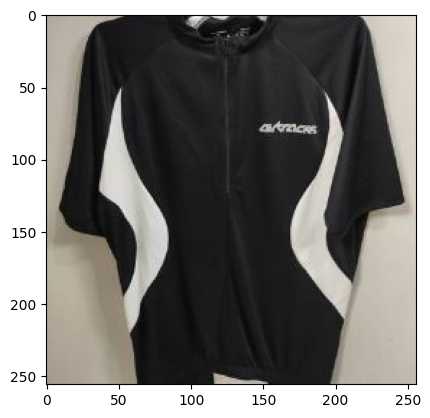

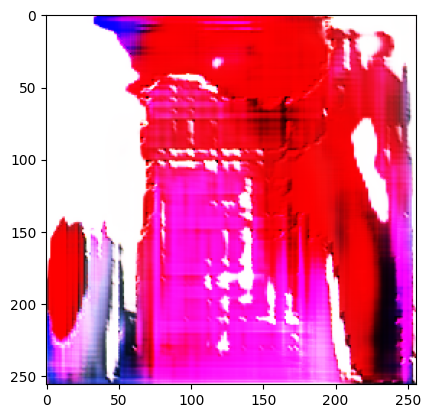

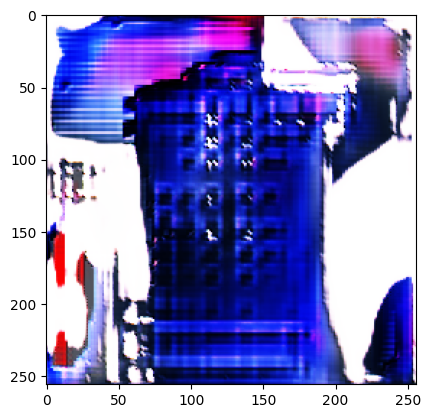

1/1 [==============================] - 0s 20ms/step
D Real: 0.08818041533231735, D Fake: 0.03270420432090759, G All: 4.869905948638916
1/1 [==============================] - 0s 21ms/step
D Real: 0.05617878586053848, D Fake: 0.08280380815267563, G All: 5.384481430053711
1/1 [==============================] - 0s 19ms/step
D Real: 0.7629995942115784, D Fake: 0.04817623645067215, G All: 4.126255989074707
1/1 [==============================] - 0s 19ms/step
D Real: 0.06156758964061737, D Fake: 0.05708012357354164, G All: 4.07581090927124
1/1 [==============================] - 0s 18ms/step
D Real: 0.10157734155654907, D Fake: 0.04509437829256058, G All: 3.65228009223938
1/1 [==============================] - 0s 19ms/step
D Real: 0.11164899170398712, D Fake: 0.051129601895809174, G All: 3.557900905609131
1/1 [==============================] - 0s 20ms/step
D Real: 0.05457375943660736, D Fake: 0.1624748408794403, G All: 3.407273292541504
1/1 [==============================] - 0s 19ms/step
D Real

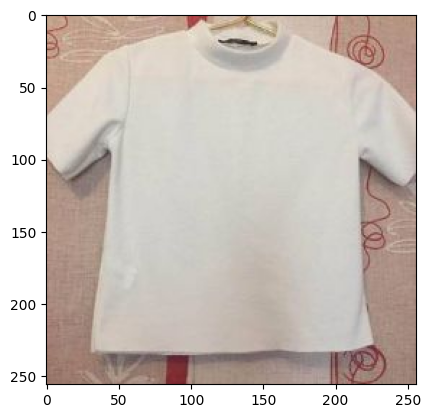

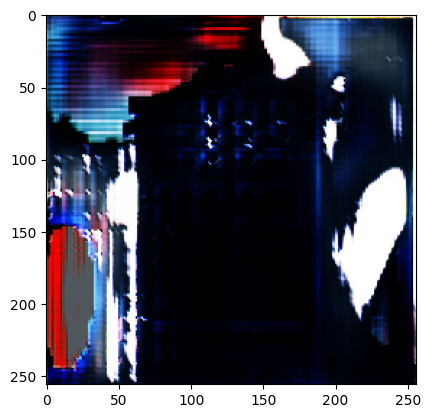

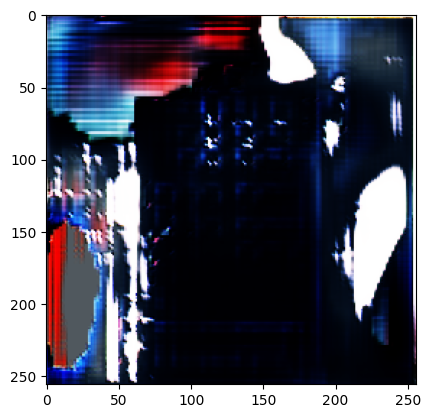

1/1 [==============================] - 0s 21ms/step
D Real: 0.155472993850708, D Fake: 0.05671127140522003, G All: 5.0105438232421875
1/1 [==============================] - 0s 19ms/step
D Real: 0.04128817468881607, D Fake: 0.05819960683584213, G All: 4.418490409851074
1/1 [==============================] - 0s 20ms/step
D Real: 0.05687978118658066, D Fake: 0.05705788731575012, G All: 4.2100677490234375
1/1 [==============================] - 0s 19ms/step
D Real: 0.21111275255680084, D Fake: 0.1104930192232132, G All: 3.8401052951812744
1/1 [==============================] - 0s 21ms/step
D Real: 0.06607545167207718, D Fake: 0.06347193568944931, G All: 4.664966583251953
1/1 [==============================] - 0s 22ms/step
D Real: 0.05035411939024925, D Fake: 0.03327765315771103, G All: 4.1800031661987305
1/1 [==============================] - 0s 20ms/step
D Real: 0.04533827677369118, D Fake: 0.037614092230796814, G All: 3.554672956466675
1/1 [==============================] - 0s 20ms/step
D

KeyboardInterrupt: 

In [ ]:
from keras.models import load_model

# Charger le modèle GAN pré-entraîné
model_gan = Model_GAN()
model_gan.load(num=413)  # Charger le modèle avec le numéro approprié

# Extraire le générateur du modèle GAN chargé
generator_model = model_gan.generator

# Sauvegarder le générateur pré-entraîné (au cas où)
generator_model.save("/content/drive/MyDrive/GAN_mardi/Models4/generator_pretrained.h5")

# Afficher un résumé du générateur pré-entraîné
generator_model.summary()

# Entraîner le GAN avec votre nouveau dataset d'images
print("FINE TUNING - We're off! See you in a while!")
#model.GAN.steps = 165001
while(model_gan.GAN.steps < 900000):

    #print("\n\n\n\nRound " + str(model.GAN.steps) + ":")
    model_gan.train()
    if model_gan.GAN.steps % 50 == 0:
        print("\nRound: " + str(model_gan.GAN.steps))

    if model_gan.GAN.steps % 100 == 0:
        print("\n\n\n\nRound " + str(model_gan.GAN.steps) + ":")
        model_gan.eval2(int(model_gan.GAN.steps / 100))


# Test de génération

Pour générer une image à l'aide du modèle,charger les poids du générateur à partir de "gen.h5". Le faire à l'aide de la fonction load_model

1/1 [==============================] - 0s 442ms/step


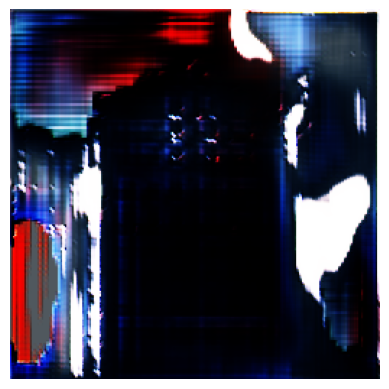

In [ ]:
from keras.layers import Input
from keras.models import load_model

# Instancier la classe GAN
gan_instance = GAN()

# Construire le modèle génératif (sans spécifier la forme des données en entrée)
generator_model = gan_instance.generator()

# Charger les poids du modèle
generator_model.load_weights("/content/drive/MyDrive/GAN_mardi/Models4/gen0.h5")

# Générer une image avec le modèle chargé
generated_image = generator_model.predict(noise(1))  # Génère une seule image

# Afficher l'image générée
plt.imshow(generated_image[0])
plt.axis('off')  # Pour désactiver les axes
plt.show()

# Fermeture de l'instance Google Collab

In [ ]:
from google.colab import runtime
runtime.unassign()